In [48]:
"""
BASED ON https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
"""

import numpy as np
from numpy.random import uniform, multivariate_normal, dirichlet, random
from numpy.linalg import norm
from gatherMatrices import getMixtureEmissionMatrices
import pickle

np.set_printoptions(linewidth=100000)

with open("../data/allDF.pickle", "rb") as f:
    df = pickle.load(f)

emissionMatrix = getMixtureEmissionMatrices(df)

In [49]:
def create_uniform_particles(
        a_range, f_range, s_range,
        n_range, i_range,
        l_range, j_range,
        N
):
    particles = np.empty((N, 7))
    for i, (var, range) in enumerate(locals().items()):
        if var[-5:] != "range": break
        particles[:, i] = uniform(range[0], range[1], size=N)
    for i, row in enumerate(particles):
        particles[i, :] = row / sum(row)

    return particles

In [50]:
def predict(particles, phi, epsilon_var):
    """
    Move alpha forward one time step according to alpha_t = phi * alpha_t-1 + epsilon
    Note: this operation is in-place
    """
    for i, alpha_t_1 in enumerate(particles):
        while True:
            epsilon = multivariate_normal(
                mean=[0 for _ in range(len(alpha_t_1))],
                cov=np.eye(len(alpha_t_1)) * epsilon_var
            )
            alpha_t = np.matmul(phi, alpha_t_1.T).squeeze() + epsilon
            if np.all(alpha_t > 0):
                break

        particles[i, :] = alpha_t


In [51]:
def estimateParticleWeight(alpha: np.array, harmony: int, N=300) -> float:
    """
    Approximate the weight of a given particle associated with a given harmony
    :param alpha: the alpha value associated with the particle
    :param harmony: the observed harmony
    :param N: number of emission particles used to estimate the transition particle weights
    :return: Estimated weight of the given particle
    """
    samples = []
    for _ in range(N):
        p = dirichlet(alpha)
        h_dist = np.matmul(p, emissionMatrix).squeeze()
        h_dist = h_dist / norm(h_dist, ord=1)
        samples.append(h_dist[harmony]) #TODO: check that harmony index is same throughout
    return sum(samples) / len(samples)


def update(particles, harmony, weights):
    for i, particle in enumerate(particles):
        weights[i] *= estimateParticleWeight(particle, harmony, 300)
    weights += 1e-300
    weights /= sum(weights)

In [83]:
def estimate(particles, weights):
    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean) ** 2, weights=weights, axis=0)
    mean = mean / sum(mean)
    return mean, var

In [53]:
def resample(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

In [54]:
def effective_N(weights):
    return 1.0 / np.sum(np.square(weights))

In [93]:
from filterpy.monte_carlo import systematic_resample
from numpy.random import randn
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def run_filter(num_particles: int, harmonies: list[int], phi: np.array=np.eye(7), plot=True):
    num_harmonies = len(harmonies)

    plt.figure()

    particles = create_uniform_particles(
        (0, 1), (0, 1), (0, 1), (0, 1),
        (0, 1), (0, 1), (0, 1),
        num_particles
    )
    weights = np.ones(num_particles) / num_particles

    estimates = []
    for i, harmony in tqdm(enumerate(harmonies), total=len(harmonies)):
        predict(particles, phi, 0.01)
        update(particles, harmony, weights)

        if effective_N(weights) < num_particles/2:
            indexes = systematic_resample(weights)
            resample(particles, weights, indexes)
            assert np.allclose(weights, 1/num_particles)

        mu, var = estimate(particles, weights)
        estimates.append(mu)

    estimates = np.array(estimates)
    print(estimates)
    if plot:
        plt.stackplot(
            range(len(harmonies)),
            estimates[:, 0], estimates[:, 1], estimates[:, 2],
            estimates[:, 3], estimates[:, 4], estimates[:, 5], estimates[:, 6]
        )
        plt.show()



  0%|          | 0/4 [00:00<?, ?it/s]

[[0.24054193 0.13050705 0.12300637 0.11722625 0.13029502 0.13213105 0.12629234]
 [0.35079404 0.10698055 0.1042405  0.11615614 0.11342964 0.10641428 0.10198485]
 [0.51728993 0.08800367 0.07614702 0.08286928 0.08560686 0.07764497 0.07243828]
 [0.65785542 0.06168322 0.05342097 0.05733553 0.05882369 0.05744743 0.05343373]]


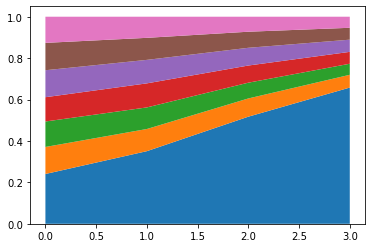

In [95]:
phi = np.array([
    [2, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])
run_filter(num_particles=900, harmonies=[2, 1, 4, 3], phi=phi)

In [57]:
particles = create_uniform_particles(
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    4
)
print(particles)
predict(particles, np.eye(7), 0.01)
weights = np.array([1/len(particles) for _ in range(len(particles))])
print(particles)
update(particles, 3, weights)
print(weights)
mean, var = estimate(particles, weights)
print(mean)

[[0.15662511 0.10943273 0.26382354 0.09743902 0.17249618 0.02689045 0.17329298]
 [0.18751357 0.17457525 0.14437346 0.02689302 0.21220926 0.06212349 0.19231194]
 [0.26278471 0.03107636 0.19660692 0.01885299 0.25717089 0.14584382 0.08766431]
 [0.24458454 0.14561847 0.18588079 0.00888036 0.23131075 0.09337632 0.09034877]]
[[0.18804403 0.1903198  0.30768432 0.08393881 0.21161682 0.01807644 0.14459576]
 [0.23379157 0.24487877 0.16439574 0.17479049 0.21248614 0.20454644 0.28553186]
 [0.44327932 0.07736522 0.16289862 0.03957032 0.33614639 0.19024221 0.24029595]
 [0.31804753 0.12164248 0.06352384 0.0687145  0.34781398 0.01192982 0.22233479]]
[0.21096883 0.2650006  0.28113889 0.24289168]
[0.30350049 0.15634088 0.16970332 0.091843   0.27993845 0.11440063 0.22773112]
